In [1]:
# change to parent directory to import module
%cd ..

/home/achilleas/projects/osbuild/metrics


In [2]:
# imports, function definitions, and global settings
import json
import pandas
import report

import numpy as np
import matplotlib.pyplot as plt
import ibmetrics as ib

from datetime import datetime, timedelta

from IPython.display import display, Markdown


def mdprint(msg):
    display(Markdown(msg))


plt.style.use('tableau-colorblind10')

In [3]:
# read data
builds = report.read_file("./data/dump-2022-10-10.log")
users = pandas.read_json("./data/userinfo.json", dtype=False)
with open("./data/userfilter.txt", encoding="utf-8") as filterfile:
    user_filter = filterfile.read().split("\n")

mdprint(f"Read {len(builds)} records")

Using cached pickle file at /home/achilleas/.cache/osbuild-metrics/dump-2022-10-10.pkl


Read 6154 records

In [4]:
# filtering: remove builds before GA
ga_date = datetime(2022, 5, 4)
ga_idxs = builds["created_at"] >= ga_date
builds = builds.loc[ga_idxs]
mdprint(f"Using {len(builds)} records (since GA)")

# filtering: remove internal users
builds = ib.data.filter_users(builds, users, user_filter)
mdprint(f"Using {len(builds)} records (after filtering)")

Using 4320 records (since GA)

Using 1787 records (after filtering)

In [5]:
summary = ib.metrics.make_summary(builds)
mdprint(ib.metrics.summarise(summary))

Summary
=======

Period: 2022-05-04 14:11:47.137615 - 2022-10-09 20:01:24.750877

- Total builds: 1787
- Number of users: 690
- Builds with packages: 1022
- Builds with filesystem customizations: 630
- Builds with custom repos: 22

Text(0.5, 1.0, 'Footprints')

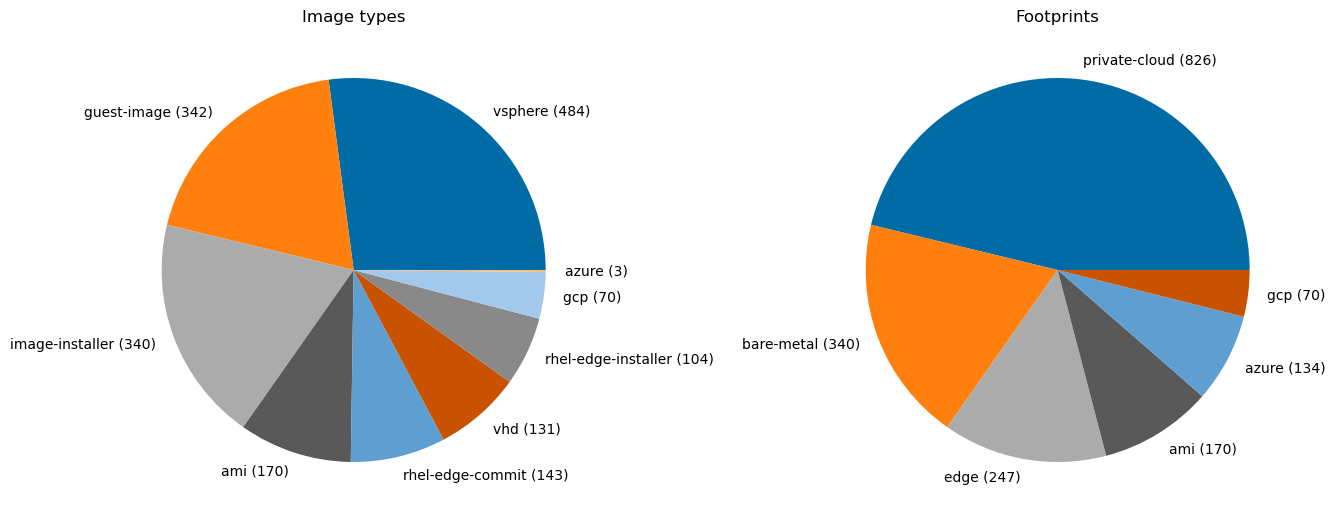

In [6]:
fig = plt.figure()
ax1 = fig.add_axes([0, 0, 1, 1])
ib.plot.imagetype_builds(builds, ax1)
ax1.set_title("Image types")

ax2 = fig.add_axes([1.1, 0, 1, 1])
ib.plot.footprint_builds(builds, ax2)
ax2.set_title("Footprints")

In [7]:
# separate builds for "edge" types
edge_idxs = builds["image_type"].str.contains("edge")
edge_builds = builds.loc[edge_idxs]
non_edge_builds = builds.loc[-edge_idxs]

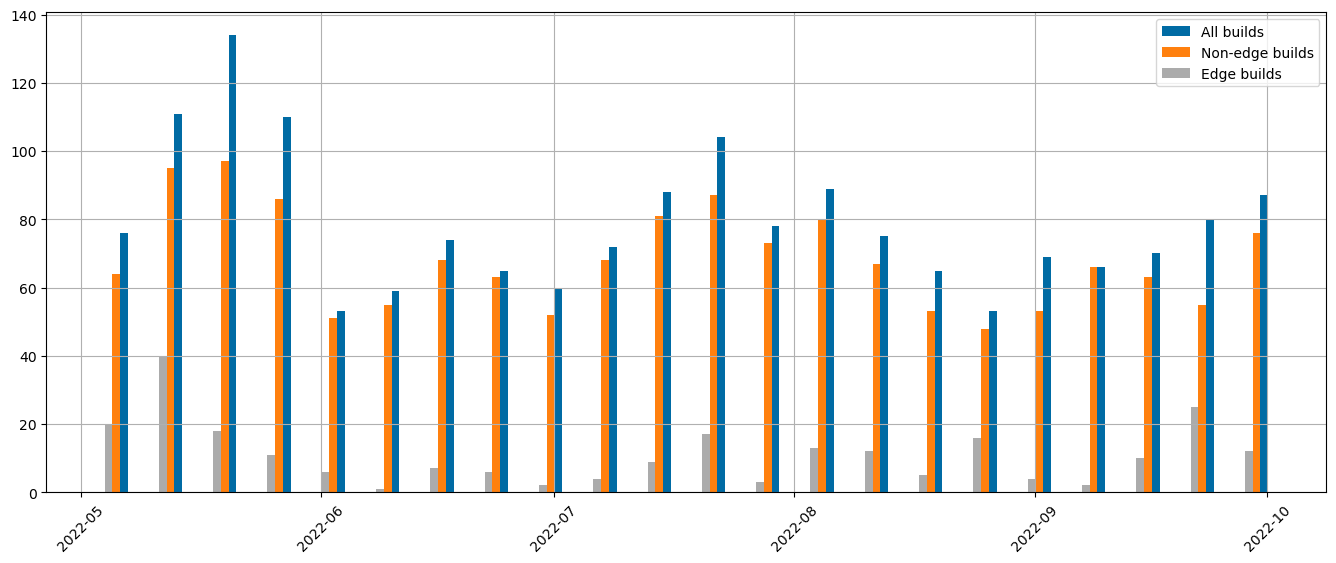

In [8]:
# builds per 7-day period for edge vs non-edge
plt.figure()
ax = plt.axes([0, 0, 2, 1])
p_days = timedelta(days=7)
bar_shift = timedelta(days=1)

e_starts, eb = ib.metrics.builds_over_time(edge_builds, p_days)
b_starts, bb = ib.metrics.builds_over_time(builds, p_days)
ne_starts, ne = ib.metrics.builds_over_time(non_edge_builds, p_days)

ax.bar(b_starts+bar_shift*2, bb, width=1, label="All builds")
ax.bar(b_starts+bar_shift, ne, width=1, label="Non-edge builds")
ax.bar(b_starts, eb, width=1, label="Edge builds")

# rotate xtick labels 45 degrees cw for readability
for label in ax.get_xticklabels():
    label.set_rotation(45)
ax.legend()
ax.grid(True)

## Users building **edge** vs **non-edge** per week.
- Users are counted based on the image type they build at any given time.
- A user that builds both an edge and non-edge type is counted in **both** categories.

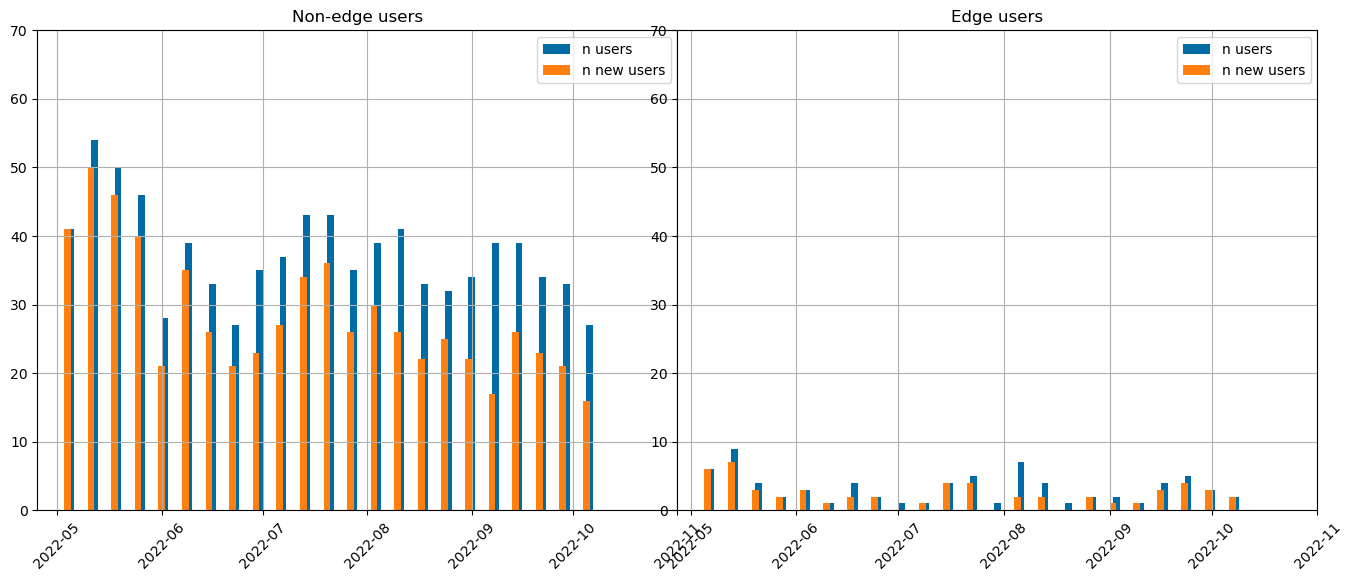

In [9]:
# Users building edge vs non-edge per week
# Users are counted based on the image type they build at any given time
# A user  that builds both an edge and non-edge type is counted in both categories
fig = plt.figure()

ymax = 70
ax1 = fig.add_axes([0, 0, 1, 1])
ib.plot.weekly_users(non_edge_builds, ax1)
ax1.set_ylim(ymin=0, ymax=ymax)
ax1.set_title("Non-edge users")

ax2 = fig.add_axes([1, 0, 1, 1])
ib.plot.weekly_users(edge_builds, ax2)
ax2.set_ylim(ymin=0, ymax=ymax)
ax2.set_title("Edge users")
mdprint("## Users building **edge** vs **non-edge** per week.\n"
"- Users are counted based on the image type they build at any given time.\n"
"- A user that builds both an edge and non-edge type is counted in **both** categories.")

In [10]:
# Separate *users* based on edge vs non-edge
# If any user builds at least one edge image, put all their builds in the edge bucket
edge_users = edge_builds["org_id"].unique()
all_users = builds["org_id"].unique()
non_edge_users = np.setdiff1d(all_users, edge_users)
print(f"Number of edge users*:    {len(edge_users):4d}")
print(f"Number of non-edge users: {len(non_edge_users):4d}")
print(f"Total users:              {len(all_users):4d}")
print('(* "edge user" is any user that has ever built at least a single edge image)')

assert len(edge_users) + len(non_edge_users) == len(all_users)

Number of edge users*:      55
Number of non-edge users:  635
Total users:               690
(* "edge user" is any user that has ever built at least a single edge image)


In [11]:
# Separate builds based on edge-tagged users
edge_user_builds_idxs = builds["org_id"].isin(edge_users)
edge_user_builds = builds.loc[edge_user_builds_idxs]
non_edge_user_builds_idxs = builds["org_id"].isin(non_edge_users)
non_edge_user_builds = builds.loc[non_edge_user_builds_idxs]

print(f"Number of builds from edge users*:    {len(edge_user_builds):4d}")
print(f"Number of builds from non-edge users: {len(non_edge_user_builds):4d}")
print(f"Total builds:                         {len(builds):4d}")
print('(* "edge user" is any user that has ever built at least a single edge image)')

assert len(edge_user_builds) + len(non_edge_user_builds) == len(builds)

Number of builds from edge users*:     315
Number of builds from non-edge users: 1472
Total builds:                         1787
(* "edge user" is any user that has ever built at least a single edge image)


## Edge vs non-edge users per week
- Users are counted as edge if they ever built at least one edge image

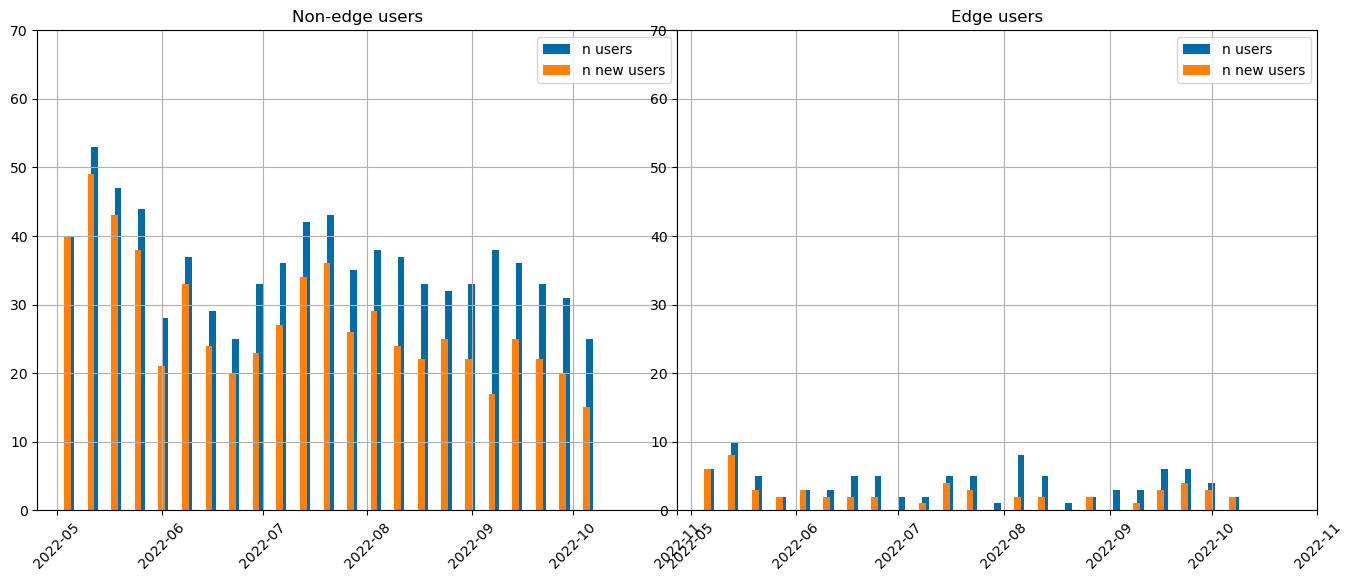

In [12]:
# Users from edge vs non-edge users
fig = plt.figure()
ymax = 70
ax1 = fig.add_axes([0, 0, 1, 1])
ib.plot.weekly_users(non_edge_user_builds, ax1)
ax1.set_ylim(ymin=0, ymax=ymax)
ax1.set_title("Non-edge users")

ax2 = fig.add_axes([1, 0, 1, 1])
ib.plot.weekly_users(edge_user_builds, ax2)
ax2.set_ylim(ymin=0, ymax=ymax)
ax2.set_title("Edge users")

mdprint("## Edge vs non-edge users per week\n"
"- Users are counted as edge if they ever built at least one edge image")

## Builds from edge vs non-edge users per week
- Users are counted as edge if they ever built at least one edge image.
- Builds from an **edge user** are counted in **Edge user builds** regardless of the type.

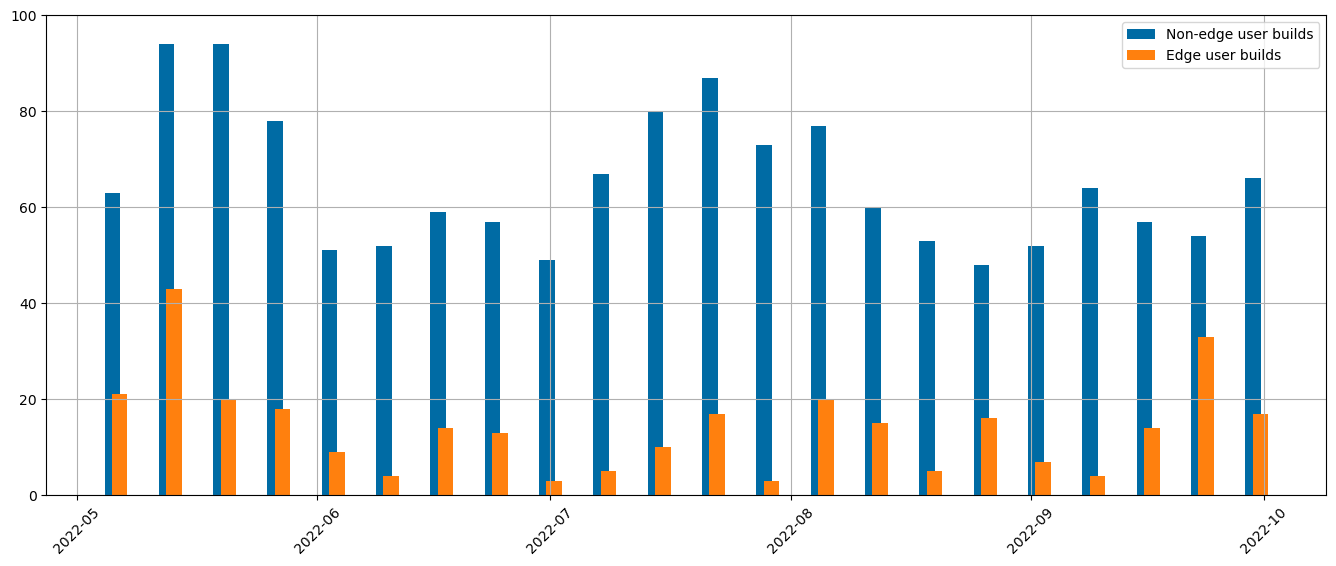

In [13]:
# builds from edge vs non-edge users
fig = plt.figure()
ax = plt.axes([0, 0, 2, 1])
ymax = 100
t_starts, non_edge_build_counts = ib.metrics.builds_over_time(non_edge_user_builds, period=timedelta(days=7))
ax.bar(t_starts+bar_shift, non_edge_build_counts, width=2, label="Non-edge user builds")

t_starts, edge_build_counts = ib.metrics.builds_over_time(edge_user_builds, period=timedelta(days=7))
ax.bar(t_starts, edge_build_counts, width=2, label="Edge user builds")
ax.legend()
ax.set_ylim(ymax=ymax)
# rotate xtick labels 45 degrees cw for readability
for label in ax.get_xticklabels():
    label.set_rotation(45)

plt.grid(True)
mdprint("## Builds from edge vs non-edge users per week\n"
    "- Users are counted as edge if they ever built at least one edge image.\n"
    "- Builds from an **edge user** are counted in **Edge user builds** regardless of the type.")

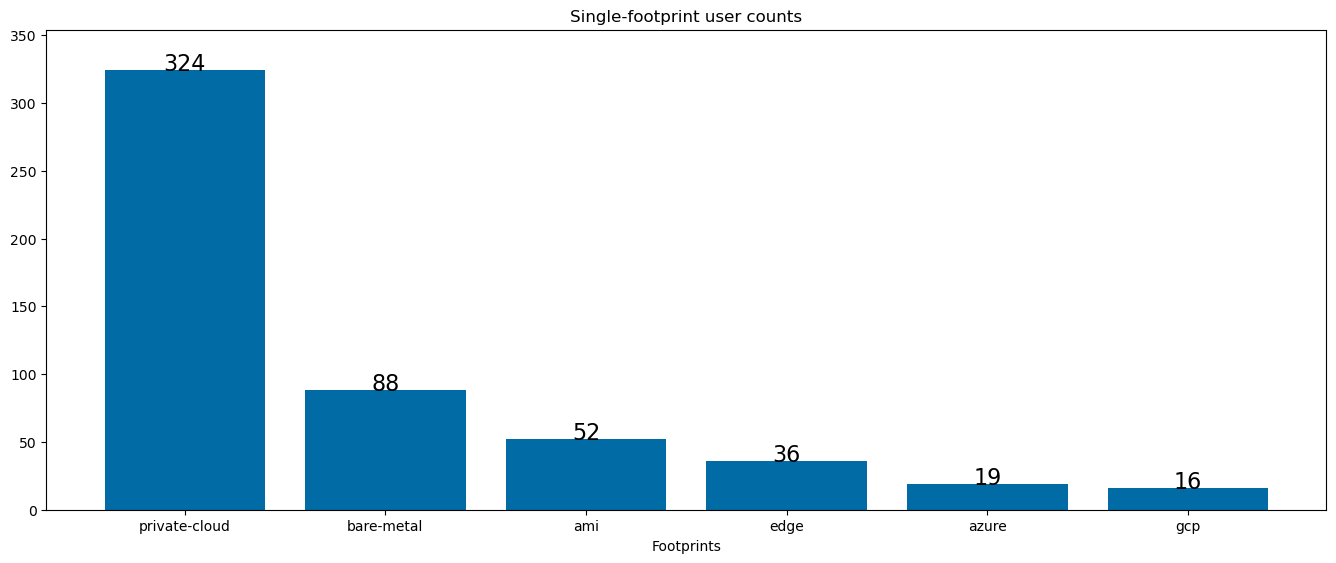

In [14]:
# distribution of single-footprint users
fig = plt.figure()
ax = plt.axes([0, 0, 2, 1])
ib.plot.single_footprint_distribution(builds, ax)

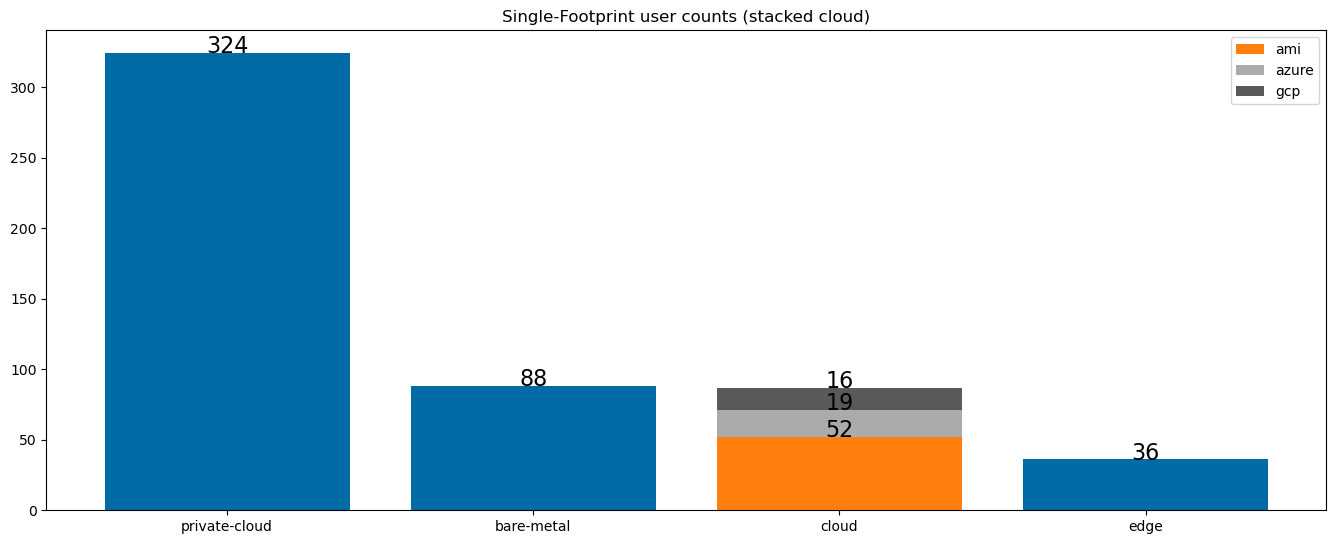

In [15]:
# distribution of single-footprint users (stacked cloud)
# it's a little hacky, but that's okay for this notebook
fig = plt.figure()
ax = plt.axes([0, 0, 2, 1])

sfp_users = ib.metrics.single_footprint_users(builds)
fp_counts = sfp_users["footprint"].value_counts()
# ax.bar(fp_counts.index, fp_counts.values)

bottom = 0
clouds = {"ami", "azure", "gcp"}
cloud_sum = sum(v if k in clouds else 0 for k, v in fp_counts.items())

cloud_grouped_feet = fp_counts.copy()
cloud_grouped_feet["cloud"] = cloud_sum
for cloud in clouds:
    del cloud_grouped_feet[cloud]

cloud_grouped_feet.sort_values(ascending=False, inplace=True)
ax.bar(cloud_grouped_feet.index, cloud_grouped_feet.values)  # plot with grouped cloud to get them in order (sorted)
for ft in cloud_grouped_feet.items():
    if ft[0] == "cloud":
        continue
    ax.text(ft[0], ft[1], str(ft[1]), size=16, ha="center")

# # draw over cloud bar with breakdown values of individual clouds
for cld in clouds:
    ax.bar("cloud", fp_counts[cld], bottom=bottom, label=cld)  
    ax.text("cloud", fp_counts[cld]+bottom, str(fp_counts[cld]), size=16, ha="center")
    bottom += fp_counts[cld]

ax.set_title("Single-Footprint user counts (stacked cloud)")
ax.legend()

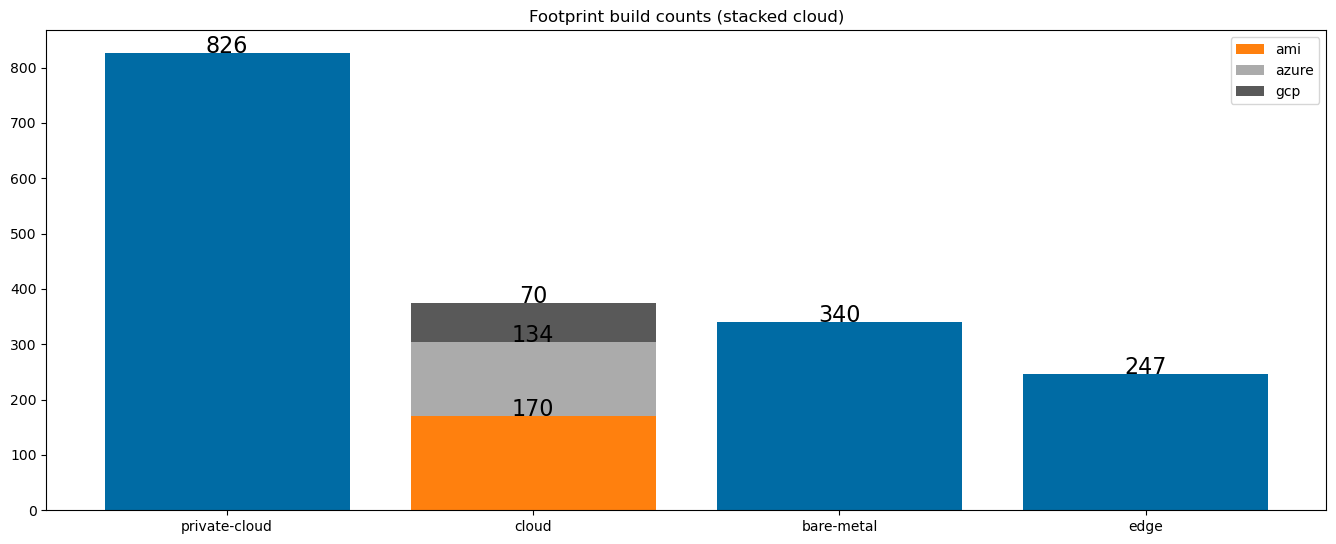

In [16]:
# distribution of builds per foorptint (stacked cloud)
# it's a little hacky, but that's okay for this notebook
fig = plt.figure()
ax = plt.axes([0, 0, 2, 1])

builds_footprints = ib.metrics.footprints(builds)
feet = builds_footprints["footprint"].value_counts()

bottom = 0
clouds = {"ami", "azure", "gcp"}
cloud_sum = sum(v if k in clouds else 0 for k, v in feet.items())

cloud_grouped_feet = feet.copy()
cloud_grouped_feet["cloud"] = cloud_sum
for cloud in clouds:
    del cloud_grouped_feet[cloud]

cloud_grouped_feet.sort_values(ascending=False, inplace=True)
ax.bar(cloud_grouped_feet.index, cloud_grouped_feet.values)  # plot with grouped cloud to get them in order (sorted)
for ft in cloud_grouped_feet.items():
    if ft[0] == "cloud":
        continue
    ax.text(ft[0], ft[1], str(ft[1]), size=16, ha="center")

# draw over cloud bar with breakdown values of individual clouds
for cld in clouds:
    ax.bar("cloud", feet[cld], bottom=bottom, label=cld)  
    ax.text("cloud", feet[cld]+bottom, str(feet[cld]), size=16, ha="center")
    bottom += feet[cld]

ax.set_title("Footprint build counts (stacked cloud)")
ax.legend()